![Diabete](img/diabete.jpeg)

# Avant-propos
___

Le dataset utilisé provient d’une étude menée sur des femmes d’origine amérindienne Pima âgées de plus de 21 ans ([**Pima Indians Diabetes**](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)). Il est souvent utilisé à des fins pédagogiques pour les problèmes de classification.

L’algorithme de régression logistique, bien qu’étant l’un des plus simples en apprentissage supervisé, est particulièrement efficace pour ce type de tâche binaire. Il est aussi facilement interprétable, ce qui en fait un excellent point de départ pour comprendre les modèles prédictifs de classification binaire.

# Introduction
___

Nous chercherons à prédire si une patiente présente un risque de diabète en fonction de caractéristiques médicales telles que son âge, son taux de glucose, sa pression artérielle, etc.

Nous allons suivre les étapes classiques d’un projet de Machine Learning : 

| Étapes                        | Description                                                                                               |
|-------------------------------| ----------------------------------------------------------------------------------------------------------|
| 1 - Data Loading              | Chargement des données (CSV, base de données, API, etc.)                                                  |
| 2 - Exploration               | Analyse des données : types, statistiques, corrélations, visualisations                                   |
| 3 - Data preparation          | Suppression des doublons, traitement des valeurs manquantes, création de features (sur tout le dataset)   |
| 4 - Train/Test Split          | Séparation des données pour évaluation (généralement 80/20 ou 70/30)                                      |
| 5 - Preprocessing             | Encodage, standardisation, etc. (fit sur le train, puis transform sur le test)                            |
| 6 - Model Training            | Entraînement du modèle sur les données d’entraînement                                                     |
| 7 - Evaluation                | Mesure des performances : MAE, MSE, R², accuracy, confusion matrix, etc..                                 |

# Import des bibliothèques
___

On commence par importer toutes les bibliothèques dont nous allons avoir besoin dans ce projet.

- **Pandas** : pour charger les données, les explorer et les modifier
- **NumPy** : pour effectuer des calculs numériques, notamment sur les tableaux
- **Matplotlib.pyplot** : pour créer des visualisations (nuages de points, courbes, histogrammes...)
- **Seaborn** : pour créer des visualisations statistiques complexes facilement, comme des heatmaps, des boxplots ou des pairplots, avec un style graphique agréable par défaut
- **Scikit-learn (sklearn)** :
  - `LogisticRegression` : pour entraîner un modèle de régression logistique
  - `train_test_split` : pour séparer les données en jeu d'entraînement et de test
  - `classification_report`, `confusion_matrix`, `accuracy_score` : pour évaluer la performance du modèle
  - `StandardScaler` : pour standardiser les données si nécessaire
- **Joblib** : pour sauvegarder ou recharger un modèle déjà entraîné

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
import joblib

# 1. 📚 Data loading
___

Commençons par charger notre dataset.

In [2]:
df = pd.read_csv("data/diabetes.csv")

# 2. 🔍 Exploration
___

### 2.1 Inspection rapide du dataset

Commençons par un **aperçu rapide** pour s’assurer que le fichier a bien été lu, que les colonnes sont correctement nommées et que les premières lignes ont du sens.

On constate que certaines variables biométriques ne peuvent pas être nulles médicalement, pourtant elles présentent des 0, par exemple :
- Glucose
- BloodPressure (pression artérielle)
- SkinThickness (épaisseur du pli cutané)
- Insulin
- BMI (indice de masse corporelle)

Il va falloir traiter traiter ces données par la suite.

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Obsevons immédiatement la structure du DataFrame pour :  
- le nombre de lignes
- le type de chaque colonne (entier, flottant, objet, etc.)
- et de repérer la présence de valeurs manquantes.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Prenons connaissance des statistiques descriptives de chaque variable du dataset.

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 2.2. Traitement des données manquantes

Le DataFrame ne contient pas de valeurs manquantes mais nous devons traiter les valeurs à 0 pour certaines variables vues précédemment.

La stratégie que nous allons adopter est :  
- **convertir** ces valeurs **0** à **NaN** pour ne pas en tenir compte lors du remplacement avec la moyenne ou la médiane
- **remplacer** les valeurs manquantes par la moyenne ou la médiane

In [6]:
cols_with_zero_invalid = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)

for col in cols_with_zero_invalid:
    df[col] = df[col].fillna(df[col].median())

### 2.3. Anlayses univariées et bivariées

Quelques visualisations de base nous aideront à mieux comprendre la répartition des classes et la corrélation entre les variables.


#### a. Répartition des classes

Le graphique ci-dessus montre la répartition de la variable cible `Outcome`, qui indique si une patiente est atteinte de diabète (`1`) ou non (`0`).

On observe clairement un **déséquilibre de classes** :

- la majorité des exemples correspondent à la classe `0` (non diabétique).
- la classe `1` (diabétique) est **moins représentée**, avec presque deux fois moins d’exemples.

En apprentissage supervisé, ce **déséquilibre de classes** peut poser plusieurs problèmes :
- le modèle peut **favoriser la classe majoritaire** pour maximiser la précision globale.
- il risque de **mal prédire les cas minoritaires**, ici les patientes réellement diabétiques.

Donc :  

> Une bonne performance globale (`accuracy`) ne suffit pas si le modèle ignore la classe minoritaire.  
> Il faut donc utiliser des **métriques adaptées** comme le `recall`, la `precision`, ou le `f1-score`.

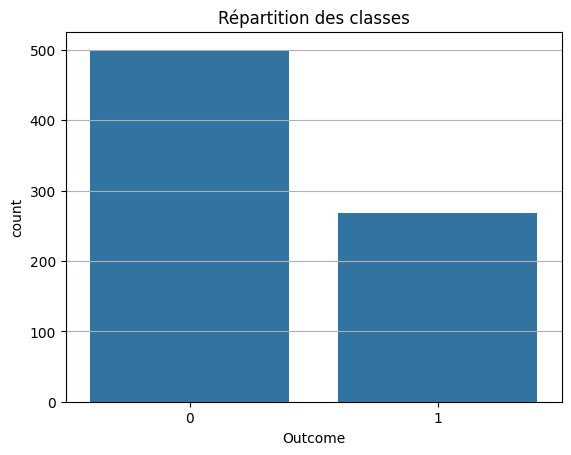

In [7]:
sns.countplot(x=df["Outcome"], data=df)
plt.title("Répartition des classes")
plt.grid(True, axis="y")
plt.show()

#### b. Distribution des features

En observant les âges, on observe :  
- une **asymétrie (skew)** marquée à droite : la majorité des patientes ont entre **20 et 40 ans**.
- très peu d'individus ont plus de 60 ans, ce qui rend cette zone de l'espace des données **peu représentée**.

Lorsque la distribution d’une variable est **très asymétrique**, cela peut :
- influencer les statistiques comme la moyenne (qui est tirée vers les grandes valeurs)
- avoir un impact sur certains modèles de machine learning sensibles aux distributions
- nécessiter des transformations (ex. : log) ou une standardisation

En observant la répartition du nombre de grossesses (`Pregnancies`), nous remarquons :
- la majorité des patientes ont eu **entre 0 et 4 grossesses**.
- un petit nombre a eu jusqu’à **17 grossesses**, ce qui constitue une **valeur extrême rare**.
- la distribution est **asymétrique**, avec une longue traîne à droite (skewed right).

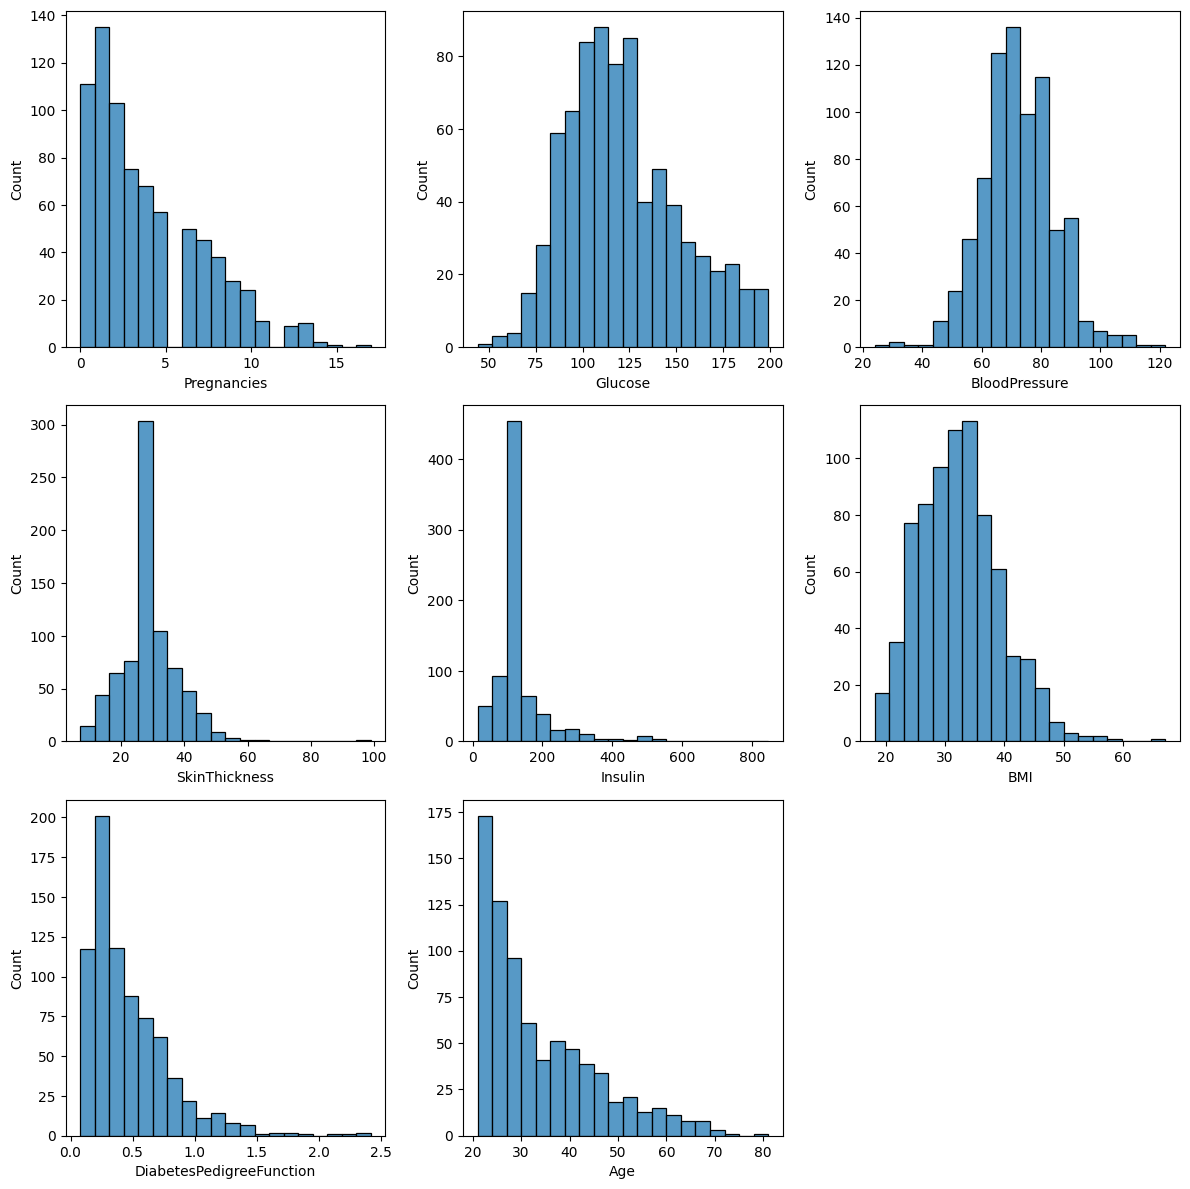

In [8]:
cols = df.columns.drop("Outcome")

plt.figure(figsize=(12,12))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### c. Relation des features avec la target

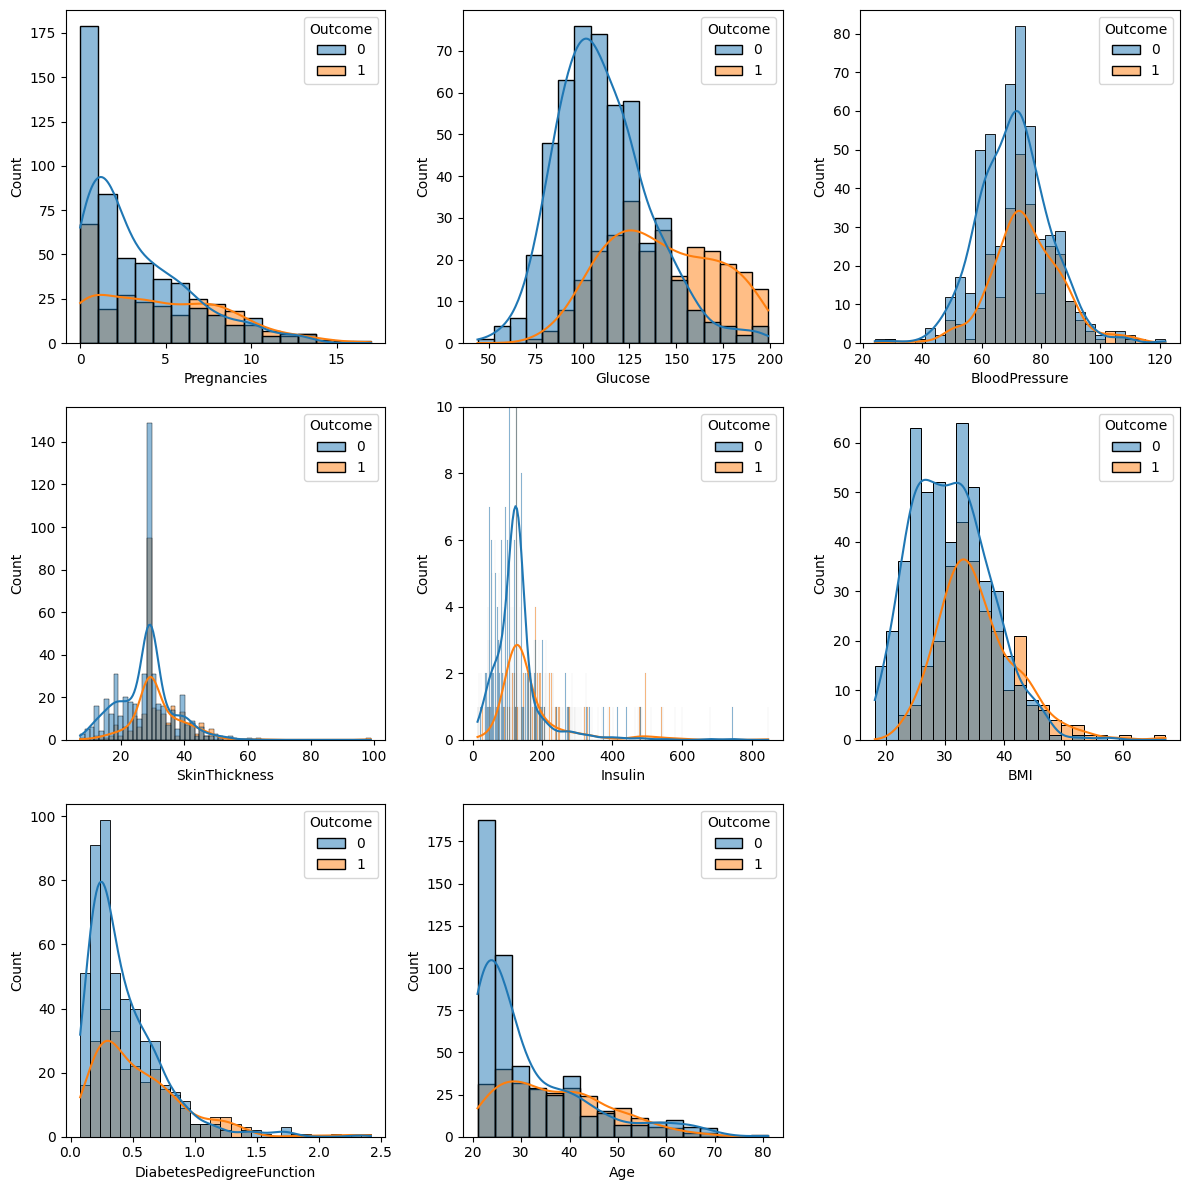

In [9]:
cols = df.columns.drop("Outcome")

plt.figure(figsize=(12,12))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, hue="Outcome", kde=True)
    if col == "Insulin":
        plt.ylim(0,10)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### d. Matrice de corrélation

La matrice ci-dessus montre la **corrélation linéaire** entre toutes les variables du dataset, y compris avec la variable cible `Outcome` (0 ou 1).

Elle permet de :
- détecter les **relations fortes entre variables** (ex. : Glucose et Insulin, ou BMI et SkinThickness),
- identifier les **variables les plus corrélées avec la cible (`Outcome`)**, et donc potentiellement les plus utiles pour la prédiction.

Que remarque t'on à la lecture de cette matrice ?

- `Glucose` est la variable **la plus corrélée** avec `Outcome` (**0.49**) → donc probablement très informative.
- `BMI`, `Age` et `Pregnancies` montrent aussi des corrélations modérées (~0.2 à 0.3).
- Les autres variables ont des corrélations plus faibles, mais peuvent tout de même contribuer au modèle.

Attention :
> Une corrélation forte avec la cible n’est pas une garantie qu’une variable sera utile, mais c’est un **indicateur précieux**.  
> Inversement, une variable faiblement corrélée peut toujours avoir un impact combiné avec d'autres dans un modèle.

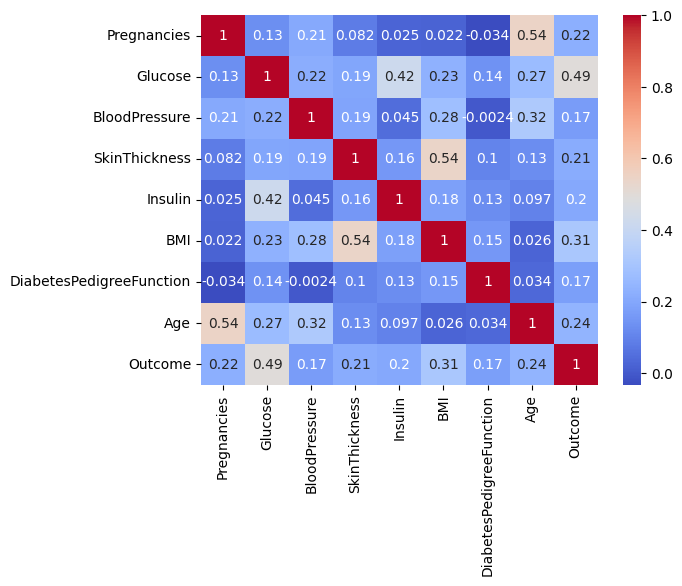

In [10]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

# 3. Data preparation
___

### Détection des valeurs aberrantes (outliers)

In [11]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (
        lower_bound, 
        upper_bound, 
        df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        )


display("Outliers Pregnancies", detect_outliers(df, "Pregnancies")[2])
display("Outliers Glucose", detect_outliers(df, "Glucose")[2])
display("Outliers BloodPressure", detect_outliers(df, "BloodPressure")[2])
display("Outliers SkinThickness", detect_outliers(df, "SkinThickness")[2])
display("Outliers Insulin", detect_outliers(df, "Insulin")[2])
display("Outliers BMI", detect_outliers(df, "BMI")[2])
display("Outliers DiabetesPedigreeFunction", detect_outliers(df, "DiabetesPedigreeFunction")[2])
display("Outliers Age", detect_outliers(df, "Age")[2])

'Outliers Pregnancies'

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
88,15,136.0,70.0,32.0,110.0,37.1,0.153,43,1
159,17,163.0,72.0,41.0,114.0,40.9,0.817,47,1
298,14,100.0,78.0,25.0,184.0,36.6,0.412,46,1
455,14,175.0,62.0,30.0,125.0,33.6,0.212,38,1


'Outliers Glucose'

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


'Outliers BloodPressure'

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
18,1,103.0,30.0,38.0,83.0,43.3,0.183,33,0
43,9,171.0,110.0,24.0,240.0,45.4,0.721,54,1
84,5,137.0,108.0,29.0,125.0,48.8,0.227,37,1
106,1,96.0,122.0,29.0,125.0,22.4,0.207,27,0
125,1,88.0,30.0,42.0,99.0,55.0,0.496,26,1
177,0,129.0,110.0,46.0,130.0,67.1,0.319,26,1
362,5,103.0,108.0,37.0,125.0,39.2,0.305,65,0
549,4,189.0,110.0,31.0,125.0,28.5,0.680,37,0
597,1,89.0,24.0,19.0,25.0,27.8,0.559,21,0
599,1,109.0,38.0,18.0,120.0,23.1,0.407,26,0


'Outliers SkinThickness'

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
16,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1
32,3,88.0,58.0,11.0,54.0,24.8,0.267,22,0
39,4,111.0,72.0,47.0,207.0,37.1,1.390,56,1
50,1,103.0,80.0,11.0,82.0,19.4,0.491,22,0
...,...,...,...,...,...,...,...,...,...
698,4,127.0,88.0,11.0,155.0,34.5,0.598,28,0
710,3,158.0,64.0,13.0,387.0,31.2,0.295,24,0
718,1,108.0,60.0,46.0,178.0,35.5,0.415,24,0
753,0,181.0,88.0,44.0,510.0,43.3,0.222,26,1


'Outliers Insulin'

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
753,0,181.0,88.0,44.0,510.0,43.3,0.222,26,1
755,1,128.0,88.0,39.0,110.0,36.5,1.057,37,1
760,2,88.0,58.0,26.0,16.0,28.4,0.766,22,0
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0


'Outliers BMI'

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
120,0,162.0,76.0,56.0,100.0,53.2,0.759,25,1
125,1,88.0,30.0,42.0,99.0,55.0,0.496,26,1
177,0,129.0,110.0,46.0,130.0,67.1,0.319,26,1
193,11,135.0,72.0,29.0,125.0,52.3,0.578,40,1
247,0,165.0,90.0,33.0,680.0,52.3,0.427,23,0
303,5,115.0,98.0,29.0,125.0,52.9,0.209,28,1
445,0,180.0,78.0,63.0,14.0,59.4,2.420,25,1
673,3,123.0,100.0,35.0,240.0,57.3,0.880,22,0


'Outliers DiabetesPedigreeFunction'

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
12,10,139.0,80.0,29.0,125.0,27.1,1.441,57,0
39,4,111.0,72.0,47.0,207.0,37.1,1.390,56,1
45,0,180.0,66.0,39.0,125.0,42.0,1.893,25,1
58,0,146.0,82.0,29.0,125.0,40.5,1.781,44,0
100,1,163.0,72.0,29.0,125.0,39.0,1.222,33,1
147,2,106.0,64.0,35.0,119.0,30.5,1.400,34,0
187,1,128.0,98.0,41.0,58.0,32.0,1.321,33,1
218,5,85.0,74.0,22.0,125.0,29.0,1.224,32,1
228,4,197.0,70.0,39.0,744.0,36.7,2.329,31,0


'Outliers Age'

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
123,5,132.0,80.0,29.0,125.0,26.8,0.186,69,0
363,4,146.0,78.0,29.0,125.0,38.5,0.520,67,1
453,2,119.0,72.0,29.0,125.0,19.6,0.832,72,0
459,9,134.0,74.0,33.0,60.0,25.9,0.460,81,0
489,8,194.0,80.0,29.0,125.0,26.1,0.551,67,0
537,0,57.0,60.0,29.0,125.0,21.7,0.735,67,0
666,4,145.0,82.0,18.0,125.0,32.5,0.235,70,1
674,8,91.0,82.0,29.0,125.0,35.6,0.587,68,0
684,5,136.0,82.0,29.0,125.0,32.3,0.640,69,0


# 4. Train/Test split
___

Pour la séparation des données, nous choisissons une répartition classique de 80 % pour l’entraînement et 20 % pour le test.

In [12]:
X = df[["Glucose", "BMI", "Age"]].values
y = df["Outcome"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# 5. Preprocessing
___

Nous mettons toutes les variables à la même échelle en utilisant le `StandardScaler`. Le scaler **apprend la moyenne et l’écart-type** sur les données d’entraînement, puis on applique cette transformation aux données d’entraînement et de test.

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Model training
___

In [14]:
model = LogisticRegression(solver="liblinear", class_weight="balanced")
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

# 7. Evaluation
___

### a. Matrice de confusion

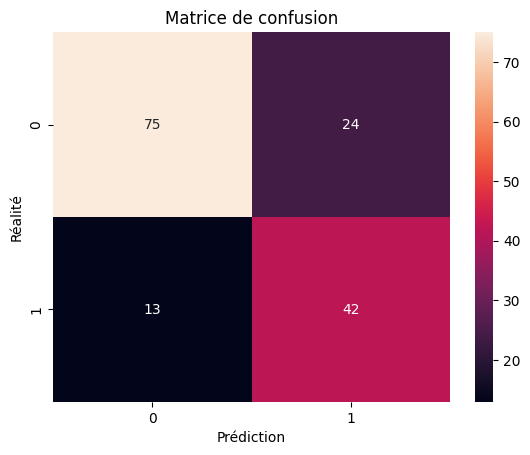

In [15]:
y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True)
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.show()

### b. Scores

In [16]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("Recall :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))

Accuracy : 0.7597402597402597
Precision : 0.6363636363636364
Recall : 0.7636363636363637
F1-score : 0.6942148760330579


# 8. Sauvegarde du modèle et des standardiseurs (scalers)
___

In [17]:
joblib.dump(model, "models/logistic_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

# Comment utiliser le modèle ?
___

In [18]:
model = joblib.load("models/logistic_model.pkl")
scaler = joblib.load("models/scaler.pkl")

input = np.array([[148, 33.6, 50]])

input_scaled = scaler.transform(input)

prediction = model.predict(input_scaled)

print(f"Prédiction (0 = pas de diabète, 1 = diabète) : {prediction[0]}")

Prédiction (0 = pas de diabète, 1 = diabète) : 1
